### IMPORT STATEMENTS

In [90]:
import pandas as pd
import numpy as np
import json
import operator
import os
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline

### READ DATA

In [2]:
businesses = pd.read_json('https://drive.google.com/open?id=0Bzg5J2f2XdnDOWRhUmQ3QXM2dFE', lines= True)
category = pd.read_json('https://drive.google.com/open?id=1Yri5_lLnbRSlIjDTNsfL5lzVkUQK4UUz', lines=True)
user = pd.read_json('https://drive.google.com/open?id=0Bzg5J2f2XdnDVE15WjhaemJQaWc', lines=True)

### JOIN DATAFRAMES ON BUSINESS IDs

In [3]:
business_data = pd.merge(businesses, category, on='business_id')
business_data = business_data.drop('categories_x',axis=1)
business_data['categories_y'] = business_data['categories_y'].apply(lambda x: list(map(lambda x: x.get('alias', ""), x)))

### GET TOP CATEGORIES

In [4]:
from collections import defaultdict

categories = defaultdict(lambda : 0)

for cats in business_data['categories_y']:
    for category in cats:
        categories[category] += 1
        
len(categories)

1067

In [5]:
sorted_x = sorted(categories.items(), key=operator.itemgetter(1),reverse=True)

required_cat = ["pizza",
                "hotdogs",
                "sandwiches",
                "tradamerican",
                "coffee",
                "italian",
                "burgers",
                "mexican",
                "breakfast_brunch",
                "chinese",
                "bars",
                "bakeries",
                "newamerican",
                "icecream",
                "cafes",
                "japanese",
                "chicken_wings",
                "sushi",
                "seafood",
                "desserts"]

required_cat

['pizza',
 'hotdogs',
 'sandwiches',
 'tradamerican',
 'coffee',
 'italian',
 'burgers',
 'mexican',
 'breakfast_brunch',
 'chinese',
 'bars',
 'bakeries',
 'newamerican',
 'icecream',
 'cafes',
 'japanese',
 'chicken_wings',
 'sushi',
 'seafood',
 'desserts']

### RESTRICT DATA TO TOP CATEGORIES

In [6]:
mask = business_data['categories_y'].apply(lambda x: len(set(x).intersection(required_cat)) > 0)

business_data = business_data[mask]

### RESTRICT TO BUSINESSES IN US

In [8]:
def in_USA(s):
    try:
        int(s)
        return len(s) == 5
    except ValueError:
        return False

In [9]:
mask2 = business_data['postal_code'].apply(in_USA)

In [10]:
business_data = business_data[mask2]

### Remove categories which are not top category list

In [12]:
business_data['categories_y'] = business_data['categories_y'].apply(lambda x: list(filter(lambda y: y in required_cat, x)))

In [14]:
path ='https://drive.google.com/open?id=1Z433xKY2Ypu3Bi09_9T1TzguwAfFgYLM'
allFiles = os.listdir(path)
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_json(path+"/"+file_,lines=True)
    list_.append(df)
frame = pd.concat(list_)

In [15]:
business_data2  = pd.merge(business_data, frame, on='business_id')
s = business_data2.apply(lambda x: pd.Series(x['categories_y']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'categories'
business_data2 = business_data2.drop('categories_y', axis=1).join(s)

In [16]:
utility = business_data2[['user_id', 'categories','stars_y', 'business_id']]
len(utility)

551171

In [17]:
business_data3 = business_data2[['user_id', 'categories','stars_y', 'business_id']].groupby(['user_id', 'categories', 'business_id'], as_index=False)
business_data3.head()

,user_id,categories,stars_y,business_id
0,Y0QwHP4oxQ4jtk8R2PFq8g,sandwiches,5,duHFBe87uNSXImQmvBh87Q
1,F_g_b3vOcP80Q1hMWdqbxQ,sandwiches,5,duHFBe87uNSXImQmvBh87Q
2,4W-ZU-E82HWWUNNk9tfN6g,sandwiches,5,duHFBe87uNSXImQmvBh87Q
3,qibGLHABNReGeJr2w4_8yQ,sandwiches,3,duHFBe87uNSXImQmvBh87Q
4,-kBt3m5oyIppBKPn1ymLyQ,sandwiches,5,duHFBe87uNSXImQmvBh87Q
5,q8pYnjIwWbgIK_H0A2Txbw,sandwiches,4,duHFBe87uNSXImQmvBh87Q
6,8jN7OEC8N67IY6MgssxoMA,sandwiches,5,duHFBe87uNSXImQmvBh87Q
7,qROJLu7oKQsFri70kSUnCg,sandwiches,4,duHFBe87uNSXImQmvBh87Q
8,OIVny4cXC6IevrYkw5EmPw,sandwiches,5,duHFBe87uNSXImQmvBh87Q
9,mzHRaYLoV-lwX79HghP6lw,sandwiches,5,duHFBe87uNSXImQmvBh87Q


In [18]:
business_data3 = business_data2[['user_id', 'categories','stars_y', 'business_id']].groupby(['user_id', 'categories', 'business_id'], as_index=False).mean()

### Category to business mapping

In [21]:
business_data = business_data.filter(['business_id', 'city', 'name', 'postal_code', 'review_count', 'stars', 'categories_y'])
business_data

,business_id,city,name,postal_code,review_count,stars,categories_y
4,duHFBe87uNSXImQmvBh87Q,Phoenix,Blimpie,85016,10,4.5,[sandwiches]
14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,Applebee's,28105,21,2.0,"[tradamerican, burgers]"
15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,China Garden,28164,3,3.0,[chinese]
18,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,Koko Bakery,44114,162,4.0,[bakeries]
21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,Rocky's,15224,15,3.0,[breakfast_brunch]
31,TXiEgINSZ75d3EtvLvkc4Q,Madison,Red Lobster,53704,45,3.0,"[seafood, tradamerican]"
36,PV9CdNFDOX4_zWm3Sy3W8g,Middleton,Quaker Steak & Lube,53562,117,3.0,"[tradamerican, chicken_wings, bars]"
42,HRFJlSAP_EBU_MpPPmpUDQ,Chandler,Domino's Pizza,85225,20,2.5,"[pizza, chicken_wings, sandwiches]"
50,FLTbKRmBytP1AbjWSPEeyw,Chandler,Szechuan Cuisine,85226,16,4.0,[chinese]
51,1AxEmgv8Dsr3iU9Aa40jPw,Chandler,"Nabers Music, Bar & Eats",85226,75,4.0,[bars]


In [22]:
business_data['categories_y'] = business_data['categories_y'].apply(lambda x: ','.join(x))
business_data

,business_id,city,name,postal_code,review_count,stars,categories_y
4,duHFBe87uNSXImQmvBh87Q,Phoenix,Blimpie,85016,10,4.5,sandwiches
14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,Applebee's,28105,21,2.0,"tradamerican,burgers"
15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,China Garden,28164,3,3.0,chinese
18,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,Koko Bakery,44114,162,4.0,bakeries
21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,Rocky's,15224,15,3.0,breakfast_brunch
31,TXiEgINSZ75d3EtvLvkc4Q,Madison,Red Lobster,53704,45,3.0,"seafood,tradamerican"
36,PV9CdNFDOX4_zWm3Sy3W8g,Middleton,Quaker Steak & Lube,53562,117,3.0,"tradamerican,chicken_wings,bars"
42,HRFJlSAP_EBU_MpPPmpUDQ,Chandler,Domino's Pizza,85225,20,2.5,"pizza,chicken_wings,sandwiches"
50,FLTbKRmBytP1AbjWSPEeyw,Chandler,Szechuan Cuisine,85226,16,4.0,chinese
51,1AxEmgv8Dsr3iU9Aa40jPw,Chandler,"Nabers Music, Bar & Eats",85226,75,4.0,bars


In [23]:
business_data.to_csv('Business_category_mapping.csv', sep = ';', index=False)

### Aggregating rating values by rolling up it to user level

In [24]:
dummies = pd.get_dummies(business_data3['categories'])

In [25]:
data = business_data3.drop('categories', axis=1).join(dummies)

In [26]:
merged_data = pd.merge(data, user[user.review_count > 10][[ 'user_id']], on='user_id')

In [28]:
for cat in required_cat:
    merged_data[cat] = merged_data.apply(lambda x: x['stars_y']*x[cat], axis=1)

In [29]:
merged_data = merged_data.drop('stars_y', axis=1)

In [30]:
merged_data = merged_data.replace(0,np.NAN)

In [31]:
u_matrix = merged_data.groupby(['user_id'], as_index=False).mean()

In [32]:
u_matrix

,user_id,bakeries,bars,breakfast_brunch,burgers,cafes,chicken_wings,chinese,coffee,desserts,...,icecream,italian,japanese,mexican,newamerican,pizza,sandwiches,seafood,sushi,tradamerican
0,---1lKK3aKOuomHnwAkAow,4.0,5.0,5.0,NaN,4.0,NaN,NaN,5.000000,NaN,...,NaN,1.0,NaN,NaN,5.0,5.000000,NaN,NaN,NaN,NaN
1,---cu1hq55BP9DWVXXKHZg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,--2HUmLkcNHZp0xw6AMBPg,NaN,NaN,5.0,5.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.5,5.0,NaN,NaN,5.0,NaN,NaN
3,--3WaS23LcIXtxyFULJHTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
4,--4rAAfZnEIAKJE80aIiYg,NaN,5.0,2.0,5.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,NaN,NaN
5,--6Ke7_lBBM6XAramtPoWw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
6,--A4pFATzQJx9n4l1IAC3A,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
7,--ChzqcPs4YFWlw1jv92hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,--DxiDMQgN08E5gTM0aj7Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
9,--HCoE1ghaAlcaAfshICgw,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,5.0,5.000000,NaN,5.0,NaN,NaN


In [33]:
# u_matrix.to_csv('collaborative_filtering.csv', index=False)

In [34]:
u_matrix = u_matrix.replace(np.NAN,0)

In [35]:
u1 = u_matrix.values
u1 = np.delete(u1, [0], axis=1)

### Creating similarity matrix

In [36]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

In [37]:
# Similarity matrix for user
def sim_user(u): 
    return sim_matrix(u)

# Similarity matrix for categories
def sim_categories(u):
    return sim_matrix(u.T)

### K-neighborhood calculation

In [38]:
def top_k(arr, self_idx, k):
    new_arr = np.argsort(-arr)[1:]
    d = dict()
    for i in range(0,k):
            d[new_arr[i]] = arr[new_arr[i]]  
    return d

### Recommend via similar user

In [39]:
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    num = 0
    den = 0
    d = top_k(m_sim_users[:,user_idx], user_idx, k)        
    for key,value in d.items():
        if m_utility[key][item_idx] != 0:
            num += m_utility[key][item_idx] * value
            den += value
    if den ==0 or  num==0 :
        return 0
    return num/den

### Creating utility matrix

In [40]:
# Generating utility matrix
unique_users = utility.user_id.unique()
unique_business = utility.business_id.unique()
num_users = unique_users.shape[0]
num_business = unique_business.shape[0]

user_index = {}
index = 0
for each_user in unique_users:
    user_index[each_user] = index
    index += 1
    
business_index = {}
index = 0
for each_business in unique_business:
    business_index[each_business] = index
    index += 1
    
utility_m = np.zeros((num_users, num_business))

for idx,rating in utility.iterrows():
    utility_m[user_index[rating.user_id], business_index[rating.business_id]] = rating.stars_y

In [42]:
# Mean Squared error
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

In [83]:
# Evaluation
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    
    true = []
    pred = []
    item_id = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0.0:
                
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if(p == 5):
                    item_id.append(item_idx)
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                    
    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_user(utility_m)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility_m, similarity_users, i+1, 1000))

### K vs MSE Plot

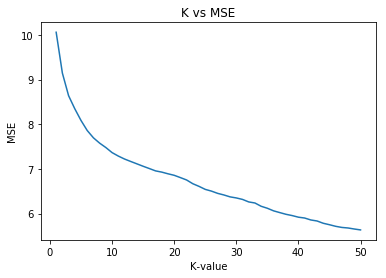

In [91]:
plt.plot(ks,mses)
plt.title("K vs MSE")
plt.xlabel("K-value")
plt.ylabel("MSE")

### Checking for a user with index 789

In [98]:
USER_ID = 789
ITEM_Array = [20, 2633, 20, 5344, 20, 4314, 2730, 22, 916, 6, 14, 3, 3463, 21, 1780, 3, 1012, 20, 3123, 4879, 13, 20, 9, 3336, 3, 3, 5301, 20, 1844, 3, 3, 20, 5026, 6, 4079, 9, 5256, 4989, 13, 9, 1844, 2913, 0, 21]

business_reco = []
for each_user in user_index:
    if user_index[each_user] == USER_ID:
        print("UserID:", each_user)
        break
print("Recommendations:")
for each_b in business_index:
    if business_index[each_b] in ITEM_Array:
        business_reco += [each_b]
        print("BusinessID:", each_b)

UserID: 7FOSP2JRTdlNNFI0HyZsMg
Recommendations:
BusinessID: duHFBe87uNSXImQmvBh87Q
BusinessID: 1cLXGXThDYZ5WK_KpBLtkw
BusinessID: PV9CdNFDOX4_zWm3Sy3W8g
BusinessID: 1AxEmgv8Dsr3iU9Aa40jPw
BusinessID: 01xXe2m_z048W5gcBFpoJA
BusinessID: Bl7Y-ATTzXytQnCceg5k6w
BusinessID: wsyNO9Ac4gqGYTBfNeM1VA
BusinessID: JA-WeSdtaFagoI6doN0Sbw
BusinessID: YTqtM2WFhcMZGeAGA08Cfg
BusinessID: 34PMhyoSQHVd4Lr7slzUcA
BusinessID: 97V91GSG-OQvrvOc9GXoGA
BusinessID: phrJCsa0I_OEWExpiTET8A
BusinessID: VyVIneSU7XAWgMBllI6LnQ
BusinessID: n62dcL1e8BQA1_kUEYrldQ
BusinessID: OZVjQy15DdNsSW3bRAL4mw
BusinessID: 6We2O5X62J_gduXU7jvf8w
BusinessID: MVIthKWqwkQz0dai7LkVzQ
BusinessID: BhzbId_o7t-1q349J1L5Dg
BusinessID: jmTirQw-n4V_Z4g1-RE9iw
BusinessID: 6okGKL2PA7kkc-GjZzNHnA
BusinessID: QnZ7YUoAJNP99oFkS9IpXw
BusinessID: CDqPVVvQtVncNQGydnZy7A
BusinessID: 2jau7OtoplE60-o2TIn6Tg
BusinessID: 3l54GTr8-E3XPbIxnF_sAA
BusinessID: GlwOGCjSzts7AnbK9gqmng
BusinessID: QqbZA4r5g1vCbOxOAKJgWg
BusinessID: sj9EGBYtg-k2wddhKmrAKw


### Removing businesses already tried/rated by the user

In [92]:
reco = business_data3[business_data3['user_id'] == '7FOSP2JRTdlNNFI0HyZsMg']

In [93]:
reco1 = reco['business_id'].unique()
reco['categories'].unique()

array(['mexican'], dtype=object)

### Getting the final list of recommended business for the user

In [100]:
recommended_business = []
for b in business_reco:
    if b not in reco1:
        recommended_business.append(b)

In [110]:
print("For user id 7FOSP2JRTdlNNFI0HyZsMg, list of recommended businesses are:")
businesses[businesses['business_id'].isin(recommended_business)][['name', 'categories']]

For user id 7FOSP2JRTdlNNFI0HyZsMg, list of recommended businesses are:


,name,categories
4,Blimpie,"[Sandwiches, Restaurants]"
18,Koko Bakery,"[Food, Bakeries, Coffee & Tea]"
36,Quaker Steak & Lube,"[Burgers, Chicken Wings, Bars, Restaurants, Am..."
51,"Nabers Music, Bar & Eats","[Nightlife, Restaurants, Bars]"
70,Five Guys,"[American (New), Burgers, Fast Food, Restaurants]"
79,Sidewalk Cafe Painesville,"[American (Traditional), Breakfast & Brunch, R..."
105,Smallcakes Cave Creek,"[Ice Cream & Frozen Yogurt, Food, Cupcakes]"
107,Mariscos Playa Escondida,"[Seafood, Restaurants, Specialty Food, Ethnic ..."
4876,Zaba's Mexican Grill,"[Restaurants, Mexican]"
5335,Phusion Cafe,"[Restaurants, Chinese, Taiwanese, Asian Fusion]"
